In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings("ignore")

In [2]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_path = "cell_images\\cell_images\\train"
test_path  = "cell_images\\cell_images\\test"

In [4]:
image_shape = (130, 130, 3)

In [5]:
image_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1 ,
                               shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode = 'nearest')

In [6]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [7]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [8]:
train_image_gen = image_gen.flow_from_directory(train_path, target_size=image_shape[:2], color_mode='rgb', batch_size=32, class_mode='binary')

Found 24958 images belonging to 2 classes.


In [9]:
test_image_gen = image_gen.flow_from_directory(test_path, target_size=image_shape[:2], color_mode='rgb', batch_size=32, class_mode='binary',
                                               shuffle=False)

Found 2600 images belonging to 2 classes.


In [10]:
ConvNeXtXLarge_model = Sequential()

pretrained_model= tf.keras.applications.ConvNeXtXLarge(include_top=False,
                   input_shape=image_shape,
                   pooling='max',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

ConvNeXtXLarge_model.add(pretrained_model)

ConvNeXtXLarge_model.add(Flatten())
ConvNeXtXLarge_model.add(Dense(128, activation='relu'))
ConvNeXtXLarge_model.add(Dense(1, activation='sigmoid'))

1393257616/1393257616 [==============================] - 120s 0us/step


In [11]:
ConvNeXtXLarge_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_xlarge (Functional  (None, 2048)             348147968 
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 348,410,369
Trainable params: 262,401
Non-trainable params: 348,147,968
_________________________________________________________________


In [12]:
ConvNeXtXLarge_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [14]:
ConvNeXtXLarge_model.fit(train_image_gen, epochs=50, validation_data=test_image_gen, callbacks=[early_stop])

Epoch 1/50
780/780 [==============================] - 288s 336ms/step - loss: 0.1718 - accuracy: 0.9372 - val_loss: 0.1568 - val_accuracy: 0.9415
Epoch 2/50
780/780 [==============================] - 228s 292ms/step - loss: 0.1377 - accuracy: 0.9504 - val_loss: 0.1610 - val_accuracy: 0.9412
Epoch 3/50
780/780 [==============================] - 229s 294ms/step - loss: 0.1335 - accuracy: 0.9512 - val_loss: 0.1447 - val_accuracy: 0.9500
Epoch 4/50
780/780 [==============================] - 228s 292ms/step - loss: 0.1260 - accuracy: 0.9535 - val_loss: 0.1306 - val_accuracy: 0.9535
Epoch 5/50
780/780 [==============================] - 225s 289ms/step - loss: 0.1239 - accuracy: 0.9547 - val_loss: 0.1459 - val_accuracy: 0.9442
Epoch 6/50
780/780 [==============================] - 225s 288ms/step - loss: 0.1218 - accuracy: 0.9546 - val_loss: 0.1378 - val_accuracy: 0.9481
Epoch 7/50
780/780 [==============================] - 270s 346ms/step - loss: 0.1202 - accuracy: 0.9562 - val_loss: 0.1307 -

In [15]:
history = pd.DataFrame(ConvNeXtXLarge_model.history.history)

In [16]:
history.head()

,loss,accuracy,val_loss,val_accuracy
0,0.171845,0.937174,0.156824,0.941538
1,0.137738,0.950357,0.161038,0.941154
2,0.133530,0.951238,0.144685,0.950000
3,0.126024,0.953522,0.130608,0.953462
4,0.123922,0.954724,0.145880,0.944231


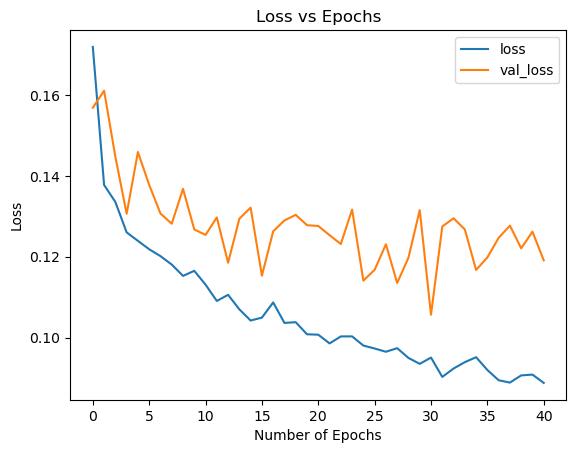

In [17]:
history[["loss", "val_loss"]].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.savefig('LossVsEpochsConNXtXL.png')
plt.show()

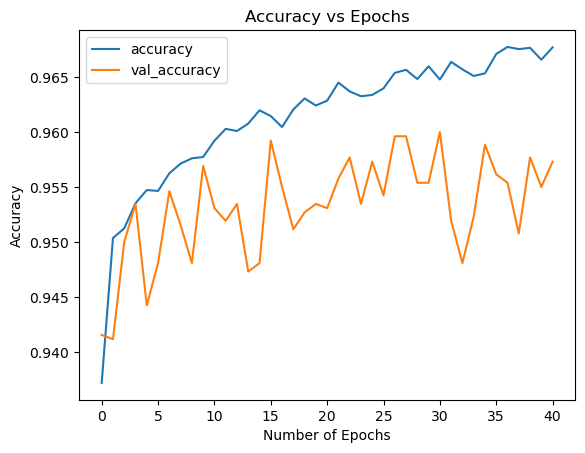

In [18]:
history[['accuracy', 'val_accuracy']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.savefig('AccuracyvsEpochsConNXtXL.png')
plt.show()

In [19]:
predictions = ConvNeXtXLarge_model.predict(test_image_gen)

82/82 [==============================] - 25s 256ms/step


In [20]:
predictions = predictions >= 0.5

In [21]:
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1300
           1       0.95      0.97      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600



In [22]:
confusion_matrix(test_image_gen.classes, predictions)

array([[1230,   70],
       [  41, 1259]], dtype=int64)

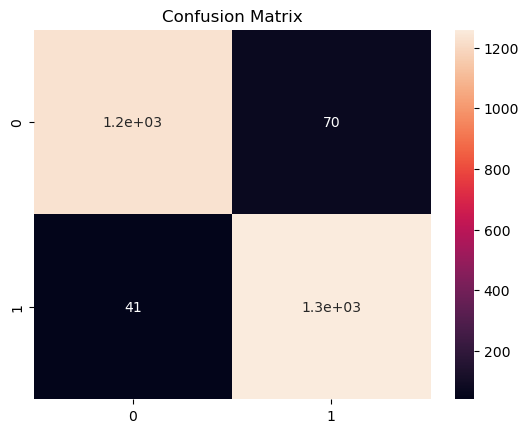

In [23]:
import seaborn as sns
DetaFrame_cm = pd.DataFrame(confusion_matrix(test_image_gen.classes, predictions), range(2), range(2))
sns.heatmap(DetaFrame_cm, annot=True)
plt.title("Confusion Matrix")
plt.savefig('ConfusionMatrixHeatmapConNXtXL.png')
plt.show()

In [24]:
ConvNeXtXLarge_model.save("MalariaPredictionsConNXtXL.h5")